Using device: cuda:0
--- Training Base Model ---


Training Base:   0%|          | 0/10000 [00:00<?, ?it/s]

Base model training complete.

--- Running Experiment 1: FID vs. w ---


Sweeping s_scale for FID:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipython-input-2990196653.py:125: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  s, _ = scipy.linalg.sqrtm(sigma @ sigma_r, disp=False)


📌 Saving Model for Layer-Wise Experiment! (FID=0.0355 at W=0.28)
Experiment 1 finished. Results saved to 'fid_vs_w_results.csv'

--- Running Experiment 2: Cosine Similarity vs. s_scale ---


Sweeping s_scale for Cosine Similarity:   0%|          | 0/46 [00:00<?, ?it/s]

Experiment 2 finished. Results saved to 'cosine_similarity_results.csv'

--- Plotting Results ---


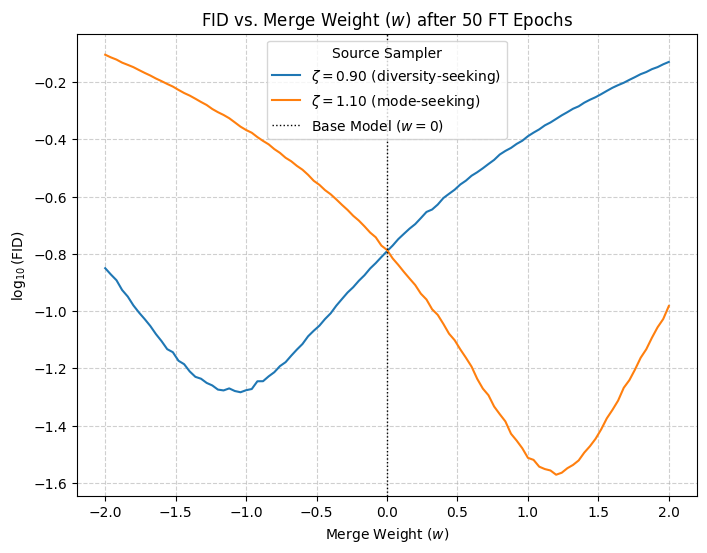

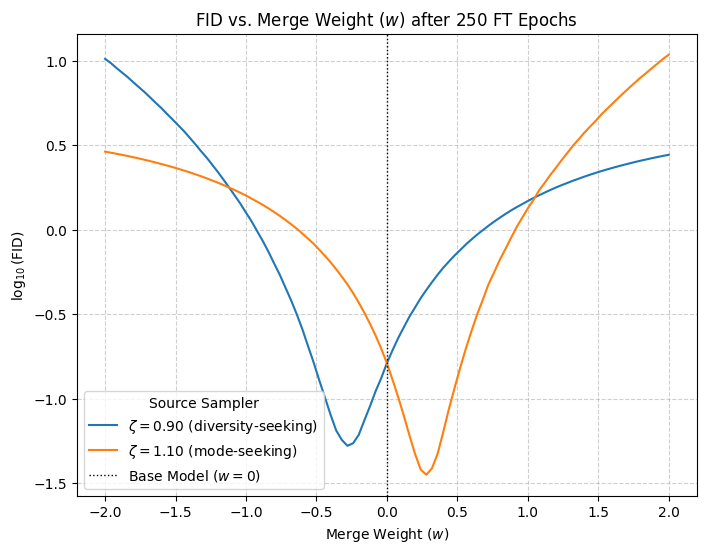

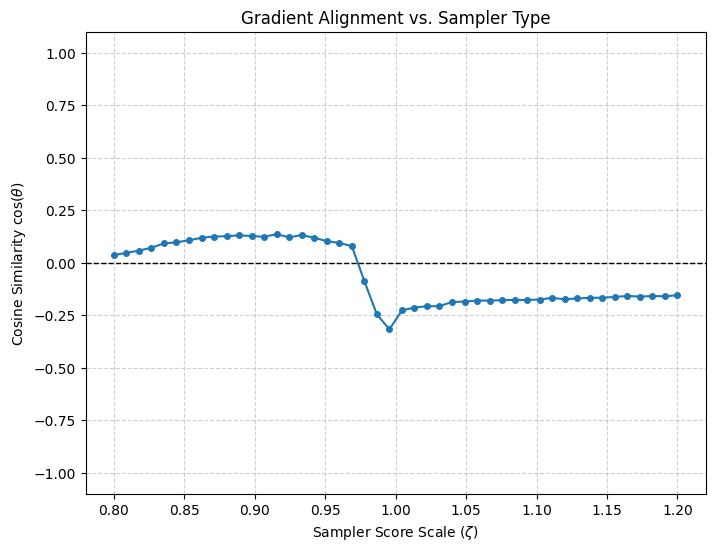

In [ ]:
##The Original toy problem from NEON appendix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import transforms
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import copy
import scipy.linalg

# ---------- Params ----------
device_str = "cuda:0"
diffusion_steps = 1000
FID_SAMPLES = 1000000
N_base = 10**3
EPOCHS_BASE = 10000
LR_BASE = 1e-4


# ---------- Repro / Device ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------- Target Gaussian ----------
D = 2
sigma_ref = np.array([[2.0, 1.0], [1.0, 2.0]], dtype=np.float64)
mu_ref = np.zeros((D,), dtype=np.float64)

# ---------- Schedules ----------
def make_cosine_schedule(n_steps: int, s: float = 0.008, device=None):
    device = device or torch.device("cpu")
    t = torch.arange(0, n_steps, dtype=torch.float32, device=device)
    schedule = torch.cos((t / n_steps + s) / (1 + s) * torch.pi / 2) ** 2
    baralphas = schedule / schedule[0]
    betas = 1.0 - baralphas / torch.cat([baralphas[0:1], baralphas[:-1]])
    alphas = 1.0 - betas
    return {"alphas": alphas, "betas": betas, "baralphas": baralphas}

train_sched = make_cosine_schedule(diffusion_steps, device=device)

# ---------- Model & Utilities ----------
def noise(Xbatch: torch.Tensor, t_idx: torch.Tensor, baralphas: torch.Tensor):
    baralpha_t = baralphas[t_idx.squeeze(-1)].unsqueeze(-1)
    eps = torch.randn_like(Xbatch)
    noised = baralpha_t.sqrt() * Xbatch + (1.0 - baralpha_t).sqrt() * eps
    return noised, eps

class DiffusionBlock(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.l = nn.Linear(n, n)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.l(x))

class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 4, nunits: int = 32):
        super().__init__()
        self.inb = nn.Linear(nfeatures + 1, nunits)
        self.mbs = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.out = nn.Linear(nunits, nfeatures)
    def forward(self, x: torch.Tensor, t: torch.Tensor, n_steps: int) -> torch.Tensor:
        if t.dtype not in (torch.float32, torch.float64):
            t = t.float()
        t_scaled = t / max(1, n_steps - 1)
        h = torch.hstack([x, t_scaled])
        h = self.inb(h)
        for block in self.mbs:
            h = block(h)
        return self.out(h)

@torch.no_grad()
def sample_diffusion(model: nn.Module, nsamples: int, nfeatures: int, n_steps: int, eta: float = 1.0, score_scale: float = 1.0) -> torch.Tensor:
    sched = make_cosine_schedule(n_steps, device=device)
    alphas, baralphas = sched["alphas"], sched["baralphas"]
    x = torch.randn((nsamples, nfeatures), device=device)

    for t in range(n_steps - 1, -1, -1):
        t_batch = torch.full((nsamples, 1), t, device=device, dtype=torch.long)
        eps_pred = model(x, t_batch, n_steps)

        bar_t = baralphas[t]
        bar_tm1 = baralphas[t-1] if t > 0 else torch.tensor(1.0, device=device)

        sqrt_bar_t = torch.sqrt(bar_t)
        sqrt_1m_bar_t = torch.sqrt(1.0 - bar_t)

        score = -eps_pred / (sqrt_1m_bar_t + 1e-9)
        score_scaled = score_scale * score

        x0_pred = (x + (1.0 - bar_t) * score_scaled) / (sqrt_bar_t + 1e-9)
        # x0_pred.clamp_(-3., 3.) # Clamping removed for more natural plots

        if t == 0:
            x = x0_pred
            break

        alpha_t = alphas[t]
        term1 = (1.0 - bar_tm1) / (1.0 - bar_t + 1e-9)
        term2 = 1.0 - alpha_t / (bar_t + 1e-9)
        sigma_t = eta * torch.sqrt(torch.clamp(term1 * term2, min=0.0))

        dir_coeff = torch.sqrt(torch.clamp(1.0 - bar_tm1 - sigma_t**2, min=0.0))

        mean = torch.sqrt(bar_tm1) * x0_pred + dir_coeff * eps_pred
        x = mean + (sigma_t * torch.randn_like(x) if (t > 0 and eta > 0.0) else 0.0)
    return x

def merge_models(base: nn.Module, other: nn.Module, w: float):
    m = copy.deepcopy(base)
    with torch.no_grad():
        for pm, pb, po in zip(m.parameters(), base.parameters(), other.parameters()):
            pm.copy_((1.0 + w) * pb - w * po)
    return m

# ---------- Metrics ----------
def calculate_fid(mu, sigma, mu_r, sigma_r) -> float:
    m = np.square(mu - mu_r).sum()
    s, _ = scipy.linalg.sqrtm(sigma @ sigma_r, disp=False)
    if not np.isfinite(s).all():
        return float('inf')
    return float(np.real(m + np.trace(sigma + sigma_r - 2.0 * s)))

def fid_of_model(model: nn.Module, nsamples: int, n_steps_infer: int) -> float:
    xs = sample_diffusion(model, nsamples, D, n_steps=n_steps_infer).cpu().numpy()
    if np.isnan(xs).any() or np.isinf(xs).any():
        return float('inf')
    return calculate_fid(xs.mean(0), np.cov(xs.T), mu_ref, sigma_ref)

# ===============================================
# ================== TRAIN BASE =================
# ===============================================
print("--- Training Base Model ---")
Xb = torch.from_numpy(np.random.multivariate_normal(mu_ref, sigma_ref, N_base).astype(np.float32))
base_model = DiffusionModel(D, nblocks=4).to(device)
opt = optim.Adam(base_model.parameters(), lr=LR_BASE)
loss_fn = nn.MSELoss()

for epoch in tqdm(range(EPOCHS_BASE), desc="Training Base"):
    for i in range(0, len(Xb), 2048):
        xb = Xb[i : i + 2048].to(device)
        t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
        noised, eps = noise(xb, t_idx, train_sched["baralphas"])
        pred = base_model(noised, t_idx, diffusion_steps)
        loss = loss_fn(pred, eps)
        opt.zero_grad()
        loss.backward()
        opt.step()
base_model.eval()
print("Base model training complete.")

# ===============================================
# === EXPERIMENT 1: FID vs. w ===
# ===============================================
print("\n--- Running Experiment 1: FID vs. w ---")
EPOCHS_LIST = [50, 250]
score_scales_fid = [0.9, 1.1]
LR_FT = 1e-5
N_aux = 10**3
ws_sweep = np.linspace(-2.0, 2.0, 101)
n_steps_eval = 20
results_fid = []
###############################CHANGE:
SAVED_AUX_MODEL = None
SAVED_BEST_W = 0.0
SAVED_BEST_FID = float('inf')
##############################END

for s_scale in tqdm(score_scales_fid, desc="Sweeping s_scale for FID"):
    Xs = sample_diffusion(base_model, nsamples=N_aux, nfeatures=D, n_steps=n_steps_eval, score_scale=s_scale).cpu()
    aux_model = copy.deepcopy(base_model).train()
    opt_ft = optim.Adam(aux_model.parameters(), lr=LR_FT)
    max_epochs = max(EPOCHS_LIST)
    for epoch in range(1, max_epochs + 1):
        for i in range(0, len(Xs), 2048):
            xb = Xs[i : i + 2048].to(device)
            t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
            noised, eps = noise(xb, t_idx, train_sched["baralphas"])
            pred = aux_model(noised, t_idx, diffusion_steps)
            loss = loss_fn(pred, eps)
            opt_ft.zero_grad(); loss.backward(); opt_ft.step()
        if epoch in EPOCHS_LIST:
            aux_model.eval()
            ################## CHANGE ##################
            local_best_fid_in_run = float('inf')
            local_best_w_in_run = 0.0
            ################## END CHANGE ##################################
            for w in ws_sweep:
                merged_model = merge_models(base_model, aux_model, w)
                fid = fid_of_model(merged_model, nsamples=FID_SAMPLES, n_steps_infer=n_steps_eval)
                results_fid.append({'epoch': epoch, 's_scale': s_scale, 'w': w, 'fid': fid})
                ###############CHANGE######################
                if fid < local_best_fid_in_run:
                    local_best_fid_in_run = fid
                    local_best_w_in_run = w
            #####################END CHANGE################
             ###############CHANGE######################
            if s_scale == 1.1 and epoch == 250:
                print(f"📌 Saving Model for Layer-Wise Experiment! (FID={local_best_fid_in_run:.4f} at W={local_best_w_in_run:.2f})")
                SAVED_AUX_MODEL = copy.deepcopy(aux_model) # שמירת עותק עמוק
                SAVED_BEST_W = local_best_w_in_run
                SAVED_BEST_FID = local_best_fid_in_run
            #####################END CHANGE################
            aux_model.train()

df_fid = pd.DataFrame(results_fid)
df_fid.to_csv('fid_vs_w_results.csv', index=False)
print("Experiment 1 finished. Results saved to 'fid_vs_w_results.csv'")

# ===============================================
# === EXPERIMENT 2: Cosine Similarity vs. s_scale ===
# ===============================================
print("\n--- Running Experiment 2: Cosine Similarity vs. s_scale ---")

def _avg_grad_over_dataset(model, X, batch_size=2048, n_t_samples=16):
    model.train()
    loss_fn = nn.MSELoss()
    per_param_grads = [torch.zeros_like(p, device=device) for p in model.parameters()]
    n_batches = (len(X) + batch_size - 1) // batch_size
    for _ in range(n_t_samples):
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size].to(device)
            t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
            x_noised, eps = noise(xb, t_idx, train_sched["baralphas"])
            model.zero_grad()
            pred = model(x_noised, t_idx, diffusion_steps)
            loss = loss_fn(pred, eps)
            loss.backward()
            for acc, p in zip(per_param_grads, model.parameters()):
                if p.grad is not None: acc.add_(p.grad)
    for acc in per_param_grads: acc.div_(n_batches * n_t_samples)
    return [g.detach() for g in per_param_grads]

def _estimate_adam_preconditioner_diagonal(model, X, batch_size=2048, n_t_samples=16, betas=(0.9, 0.999), eps=1e-8):
    beta2 = betas[1]
    model.train()
    loss_fn = nn.MSELoss()
    v = [torch.zeros_like(p, device=device) for p in model.parameters()]
    steps = 0
    for _ in range(n_t_samples):
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size].to(device)
            t_idx = torch.randint(0, diffusion_steps, (len(xb), 1), device=device)
            x_noised, eps_t = noise(xb, t_idx, train_sched["baralphas"])
            model.zero_grad()
            pred = model(x_noised, t_idx, diffusion_steps)
            loss = loss_fn(pred, eps_t)
            loss.backward()
            for vv, p in zip(v, model.parameters()):
                if p.grad is not None: vv.mul_(beta2).addcmul_(p.grad, p.grad, value=(1.0 - beta2))
            steps += 1
    bc = 1.0 - (beta2 ** steps)
    for i in range(len(v)): v[i] = v[i] / bc
    return [1.0 / (torch.sqrt(vv) + eps) for vv in v]

# --- NEW HELPER FUNCTIONS FOR COSINE SIMILARITY ---
def _dot_with_P(g1_parts, g2_parts, P_diag_parts):
    s = 0.0
    for g1, g2, pd in zip(g1_parts, g2_parts, P_diag_parts):
        s += torch.sum(g1 * (pd * g2))
    return s.item()

def _norm_with_P(g_parts, P_diag_parts):
    norm_sq = 0.0
    for g, pd in zip(g_parts, P_diag_parts):
        norm_sq += torch.sum(g * (pd * g)) # This is <g, P g>
    return torch.sqrt(norm_sq).item()

S_SCALES_align = np.linspace(0.8, 1.2, 46)
N_pop = 100_000
N_syn = 100_000

X_pop = torch.from_numpy(np.random.multivariate_normal(mu_ref, sigma_ref, size=N_pop).astype(np.float32))
g_d_pop_parts = _avg_grad_over_dataset(base_model, X_pop)
P_adam_diag_parts = _estimate_adam_preconditioner_diagonal(base_model, X_pop)
norm_d = _norm_with_P(g_d_pop_parts, P_adam_diag_parts)

cosine_similarities = []
for s_scale in tqdm(S_SCALES_align, desc="Sweeping s_scale for Cosine Similarity"):
    X_syn = sample_diffusion(base_model, nsamples=N_syn, nfeatures=D, n_steps=n_steps_eval, score_scale=s_scale)
    g_s_parts = _avg_grad_over_dataset(base_model, X_syn)

    # Calculate cosine similarity
    inner_product = _dot_with_P(g_d_pop_parts, g_s_parts, P_adam_diag_parts)
    norm_s = _norm_with_P(g_s_parts, P_adam_diag_parts)
    cos_sim = inner_product / (norm_d * norm_s + 1e-9)
    cosine_similarities.append(cos_sim)

df_align = pd.DataFrame({'s_scale': S_SCALES_align, 'cosine_similarity': cosine_similarities})
df_align.to_csv('cosine_similarity_results.csv', index=False)
print("Experiment 2 finished. Results saved to 'cosine_similarity_results.csv'")

# ===============================================
# ================== PLOTTING ===================
# ===============================================
print("\n--- Plotting Results ---")
for epoch in sorted(df_fid['epoch'].unique()):
    plt.figure(figsize=(8, 6))
    epoch_df = df_fid[df_fid['epoch'] == epoch]
    for s_scale in sorted(epoch_df['s_scale'].unique()):
        subset = epoch_df[epoch_df['s_scale'] == s_scale]
        label = f"$\\zeta={s_scale:.2f}$ (mode-seeking)" if s_scale > 1.0 else f"$\\zeta={s_scale:.2f}$ (diversity-seeking)"
        plt.plot(subset['w'], np.log10(subset['fid']), label=label)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(f"FID vs. Merge Weight ($w$) after {epoch} FT Epochs")
    plt.xlabel("Merge Weight ($w$)")
    plt.ylabel("$\\log_{10}(\\mathrm{FID})$")
    plt.axvline(0, color='k', linestyle=':', linewidth=1, label='Base Model ($w=0$)')
    plt.legend(title="Source Sampler")
    plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_align['s_scale'], df_align['cosine_similarity'], marker='o', linestyle='-', markersize=4)
plt.axhline(0.0, color='k', linestyle="--", linewidth=1)
plt.xlabel("Sampler Score Scale ($\\zeta$)")
plt.ylabel("Cosine Similarity $\\cos(\\theta)$")
plt.title("Gradient Alignment vs. Sampler Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-1.1, 1.1)
plt.show()


🚀 STARTING LAYER-WISE EXPERIMENT (USING SAVED MODEL)
Using Saved Global Baseline: W=0.28 (FID=0.0355)

Running 6-Layer Grid Search around W=0.28...
Grid values per layer: [np.float64(-1.4399999999999997), np.float64(0.28000000000000025), np.float64(2.0)]


6-Layer Sweep:   0%|          | 0/729 [00:00<?, ?it/s]

/tmp/ipython-input-2990196653.py:125: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  s, _ = scipy.linalg.sqrtm(sigma @ sigma_r, disp=False)



🔍 Verifying best config with full samples...

🏁 FINAL RESULTS COMPARISON
Global Baseline FID: 0.03554 (W=0.28)
6-Layer Best FID:    0.01100
Best Config:         (np.float64(2.0), np.float64(0.28000000000000025), np.float64(0.28000000000000025), np.float64(-1.4399999999999997), np.float64(0.28000000000000025), np.float64(2.0))


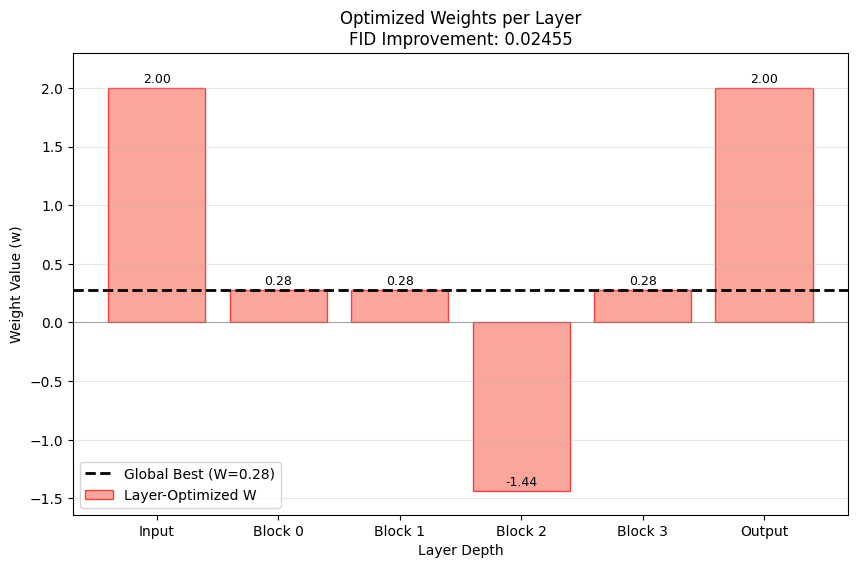


✅ SUCCESS! Improved FID by 0.02455


In [ ]:
################## START CHANGE: ניסוי 3 - אופטימיזציה לפי שכבות (מתוקן) ##################

# ===============================================
# === EXPERIMENT 3: LAYER-WISE OPTIMIZATION ===
# === (USING SAVED MODEL FROM EXP 1)        ===
# ===============================================
import itertools

print("\n" + "="*40)
print("🚀 STARTING LAYER-WISE EXPERIMENT (USING SAVED MODEL)")
print("="*40)

# וידוא שהמודל נשמר בהצלחה בניסוי 1
if SAVED_AUX_MODEL is None:
    raise ValueError("❌ Error: SAVED_AUX_MODEL is missing! Make sure Experiment 1 ran correctly with scale=1.1 and epoch=250")

print(f"Using Saved Global Baseline: W={SAVED_BEST_W:.2f} (FID={SAVED_BEST_FID:.4f})")

# 1. פונקציית מיזוג חדשה שתומכת ברשימת משקלים (אחד לכל שכבה)
def merge_models_per_layer(base: nn.Module, other: nn.Module, weights: list):
    m = copy.deepcopy(base)
    base_params = dict(base.named_parameters())
    other_params = dict(other.named_parameters())

    with torch.no_grad():
        for name, param in m.named_parameters():
            pb = base_params[name]
            po = other_params[name]

            # מיפוי שמות השכבות לאינדקסים (0-5)
            w_idx = 0
            if "inb" in name: w_idx = 0
            elif "mbs.0" in name: w_idx = 1
            elif "mbs.1" in name: w_idx = 2
            elif "mbs.2" in name: w_idx = 3
            elif "mbs.3" in name: w_idx = 4
            elif "out" in name: w_idx = 5

            w = weights[w_idx]
            # הנוסחה: (1+w)Base - w*Aux
            param.copy_((1.0 + w) * pb - w * po)
    return m

# 2. הגדרת גריד חיפוש סביב ה-W האופטימלי שמצאנו קודם
print(f"\nRunning 6-Layer Grid Search around W={SAVED_BEST_W:.2f}...")

center = SAVED_BEST_W
step = 1.72
# --- תיקון 1: הורדת מגבלת ה-max(0.0) ---
# כעת נאפשר גם ערכים שליליים אם המרכז נמוך
vals = sorted(list(set([center - step, center, center + step])))

print(f"Grid values per layer: {vals}")
# יוצר את כל הקומבינציות האפשריות (3 בחזקת 6 = 729 הרצות)
grid_6d = list(itertools.product(vals, repeat=6))

best_layerwise_fid = float('inf')
best_layerwise_config = None
SEARCH_SAMPLES = 10000 # מדגם קטן לחיפוש מהיר

# 3. הרצת החיפוש
for w_combo in tqdm(grid_6d, desc="6-Layer Sweep"):
    merged = merge_models_per_layer(base_model, SAVED_AUX_MODEL, weights=w_combo)
    # חישוב FID מהיר
    fid = fid_of_model(merged, nsamples=SEARCH_SAMPLES, n_steps_infer=20)

    if fid < best_layerwise_fid:
        best_layerwise_fid = fid
        best_layerwise_config = w_combo

# 4. אימות סופי עם מדגם מלא (אותו גודל כמו בניסוי המקורי להשוואה הוגנת)
print(f"\n🔍 Verifying best config with full samples...")
final_merged = merge_models_per_layer(base_model, SAVED_AUX_MODEL, weights=best_layerwise_config)
final_real_fid = fid_of_model(final_merged, nsamples=FID_SAMPLES, n_steps_infer=20)

# 5. הצגת התוצאות והשוואה
print("\n" + "="*40)
print("🏁 FINAL RESULTS COMPARISON")
print("="*40)
print(f"Global Baseline FID: {SAVED_BEST_FID:.5f} (W={SAVED_BEST_W:.2f})")
print(f"6-Layer Best FID:    {final_real_fid:.5f}")
print(f"Best Config:         {best_layerwise_config}")

improvement = SAVED_BEST_FID - final_real_fid

# 6. גרף השוואה (מתוקן לגרף עמודות)
plt.figure(figsize=(10, 6))
layers_names = ['Input', 'Block 0', 'Block 1', 'Block 2', 'Block 3', 'Output']

# --- תיקון 2: שימוש ב-bar plot ו-axhline ---
# ציור העמודות של התוצאה האופטימלית
bars = plt.bar(layers_names, best_layerwise_config, color='salmon', edgecolor='red', alpha=0.7, label='Layer-Optimized W')

# ציור קו אופקי שמראה את הממוצע הגלובלי
plt.axhline(y=SAVED_BEST_W, color='k', linestyle='--', linewidth=2, label=f'Global Best (W={SAVED_BEST_W:.2f})')

# הוספת תוויות ערך מעל כל עמודה
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.title(f"Optimized Weights per Layer\nFID Improvement: {improvement:.5f}")
plt.ylabel("Weight Value (w)")
plt.xlabel("Layer Depth")
# קו האפס לשם ייחוס
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(min(vals)-0.2, max(vals)+0.3) # קצת מרווח בגרף
plt.show()

if improvement > 1e-5:
    print(f"\n✅ SUCCESS! Improved FID by {improvement:.5f}")
else:
    print("\n🤷 No significant improvement found (Global W is optimal).")
################## END CHANGE ########################################################

Data loading successful.

ANALYSIS 1: Optimal Merge Weight (w)
   epoch  s_scale       w    fid  fid_baseline  improvement_perc
0     50   0.9000 -1.0400 0.0521        0.1619           67.8349
1     50   1.1000  1.2000 0.0268        0.1635           83.5928
2    250   0.9000 -0.2800 0.0527        0.1626           67.5870
3    250   1.1000  0.2800 0.0355        0.1626           78.1359

ANALYSIS 2: Gradient Alignment Theory
   s_scale  alignment  improvement_perc       w
0   0.9000     0.1270           67.8349 -1.0400
2   0.9000     0.1270           67.5870 -0.2800
1   1.1000    -0.1753           83.5928  1.2000
3   1.1000    -0.1753           78.1359  0.2800

ANALYSIS 3: Visual Interpretation of FID curves
Summary of Optimal Weights by Scale:
 s_scale  epoch       w    fid
  0.9000     50 -1.0400 0.0521
  1.1000     50  1.2000 0.0268

INTERPRETATION GUIDE FOR REPORT:
1. Each plot shows how the FID changes as we vary the extrapolation weight w.
2. The red dashed line indicates the weigh

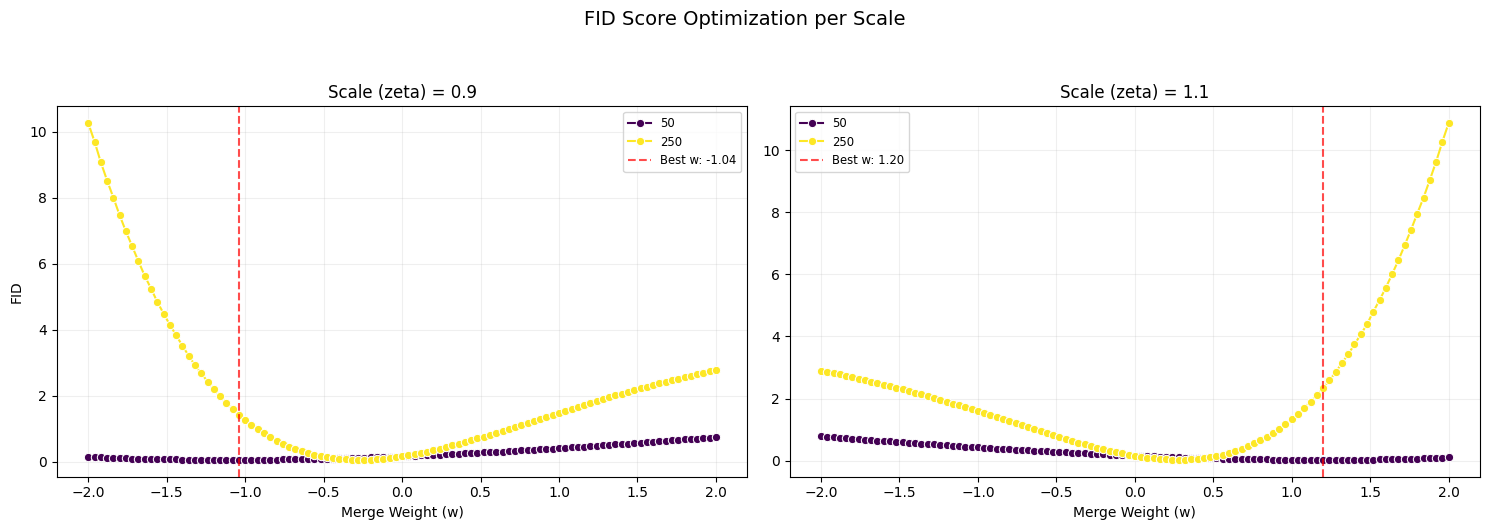

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- טעינת נתונים ---
try:
    df_fid = pd.read_csv("fid_vs_w_results.csv")
    df_cos = pd.read_csv("cosine_similarity_results.csv")
    df_fid = df_fid[np.isfinite(df_fid['fid'])]
    print("Data loading successful.")
except FileNotFoundError:
    print("Error: CSV files not found.")
    exit()

# ------------------------------------------------------------------------------
# 1. OPTIMAL MERGE WEIGHT ANALYSIS
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("ANALYSIS 1: Optimal Merge Weight (w)")
print("="*80)

idx_min = df_fid.groupby(["epoch", "s_scale"])["fid"].idxmin()
best_configs = df_fid.loc[idx_min].copy()
base_perf = df_fid[df_fid["w"] == 0].copy()
base_perf = base_perf.rename(columns={"fid": "fid_baseline"})[["epoch", "s_scale", "fid_baseline"]]
summary = best_configs.merge(base_perf, on=["epoch", "s_scale"], how="left")
summary["improvement_perc"] = (1 - (summary["fid"] / summary["fid_baseline"])) * 100

pd.options.display.float_format = '{:.4f}'.format
print(summary[["epoch", "s_scale", "w", "fid", "fid_baseline", "improvement_perc"]])

# ------------------------------------------------------------------------------
# 2. GRADIENT ALIGNMENT THEORY
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("ANALYSIS 2: Gradient Alignment Theory")
print("="*80)

def get_alignment(s):
    return df_cos.iloc[(df_cos['s_scale'] - s).abs().idxmin()]['cosine_similarity']

summary["alignment"] = summary["s_scale"].apply(get_alignment)
print(summary[["s_scale", "alignment", "improvement_perc", "w"]].sort_values("s_scale"))

# ------------------------------------------------------------------------------
# 3. IMPROVED VISUALIZATION: FID VS WEIGHT (W) PER SCALE
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("ANALYSIS 3: Visual Interpretation of FID curves")
print("="*80)

scales = df_fid['s_scale'].unique()
fig, axes = plt.subplots(1, len(scales), figsize=(15, 5), sharey=False)

if len(scales) == 1:
    axes = [axes]

for i, s in enumerate(scales):
    subset = df_fid[df_fid['s_scale'] == s]
    ax = axes[i]

    sns.lineplot(data=subset, x="w", y="fid", hue="epoch", ax=ax, marker="o", palette="viridis")

    # חישוב והדגשת הנקודה האופטימלית לסקייל זה
    best_in_scale = subset.loc[subset['fid'].idxmin()]
    ax.axvline(best_in_scale['w'], color='red', linestyle='--', alpha=0.7,
               label=f"Best w: {best_in_scale['w']:.2f}")

    ax.set_title(f"Scale (zeta) = {s}")
    ax.set_xlabel("Merge Weight (w)")
    ax.set_ylabel("FID" if i == 0 else "")
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize='small')

plt.suptitle("FID Score Optimization per Scale", fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig("clear_fid_analysis.png")

print("Summary of Optimal Weights by Scale:")
summary_table = df_fid.loc[df_fid.groupby("s_scale")["fid"].idxmin()]
print(summary_table[["s_scale", "epoch", "w", "fid"]].to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION GUIDE FOR REPORT:")
print("1. Each plot shows how the FID changes as we vary the extrapolation weight w.")
print("2. The red dashed line indicates the weight that minimizes FID (maximum quality).")
print("3. If the best w is positive, NEON successfully improved the model performance.")
print("="*80)

plt.show()

הטמעה של לפי שכבות

In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn

# ==============================================================================
# HIGH-PRECISION LAYER-WISE GRID SEARCH (MATCHING PAPER STANDARDS)
# ==============================================================================

# Configuration based on global baseline
w_global_base = 1.2
w_options = [0.9, 1.2, 1.5]
layer_names = ['Input', 'Block 1', 'Block 2', 'Block 3', 'Block 4', 'Output']

# Generate all 729 combinations
all_combinations = list(itertools.product(w_options, repeat=6))

# Use the constant defined in your previous code (1,000,000)
# Ensure FID_SAMPLES is set to 10**6 in your global parameters
precision_samples = 1000000

best_fid = float('inf')
best_weights = None
full_results = []

print("--- Starting Full Precision Grid Search (1,000,000 samples per step) ---")
print(f"Total Combinations: {len(all_combinations)}")
print(f"Standard: Matching Paper Accuracy (FID_SAMPLES = {precision_samples})")

# ------------------------------------------------------------------------------
# Grid Search Loop
# ------------------------------------------------------------------------------
for combo in tqdm(all_combinations, desc="Full Precision Evaluation"):
    # Create the model for this specific layer-wise combination
    model = merge_models_layerwise_6(base_model, aux_model, list(combo))

    # Calculate FID with maximum precision
    current_fid = fid_of_model(model, nsamples=precision_samples, n_steps_infer=n_steps_eval)

    # Store for analysis
    full_results.append({"weights": combo, "fid": current_fid})

    # Check for improvement
    if current_fid < best_fid:
        best_fid = current_fid
        best_weights = combo

# Save all results to a CSV for your report's data appendix
df_results = pd.DataFrame(full_results).sort_values("fid").reset_index(drop=True)
df_results.to_csv("layerwise_neon_full_precision_results.csv", index=False)

print("\n--- Grid Search Complete ---")
print(f"Global Winner FID: {best_fid:.6f}")
print(f"Optimal Weight List: {best_weights}")

# ------------------------------------------------------------------------------
# Final Visualization
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 7))

# Visual logic: Color baseline weights (1.2) blue, and adjustments green
colors = ['#3498db' if w == w_global_base else '#2ecc71' for w in best_weights]
bars = plt.bar(layer_names, best_weights, color=colors, edgecolor='black', alpha=0.8)

# Add the baseline red line at 1.2
plt.axhline(y=w_global_base, color='red', linestyle='-', linewidth=3,
            label=f'Global NEON Baseline (w={w_global_base})')

# Add weight values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title(f"Optimal Layer-wise Weights (Full Precision: 1M Samples)\nBest FID: {best_fid:.4f}", fontsize=15)
plt.ylabel("Extrapolation Weight (w)", fontsize=12)
plt.xlabel("Model Section", fontsize=12)
plt.ylim(0.7, 1.8)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.savefig("optimal_layerwise_weights_1M.png")
plt.show()

print("Saved data to: layerwise_neon_full_precision_results.csv")
print("Saved plot to: optimal_layerwise_weights_1M.png")

--- Starting Full Precision Grid Search (1,000,000 samples per step) ---
Total Combinations: 729
Standard: Matching Paper Accuracy (FID_SAMPLES = 1000000)


Full Precision Evaluation:   0%|          | 0/729 [00:00<?, ?it/s]

NameError: name 'base_model' is not defined

In [ ]:
print(merge_models_layerwise_6)


NameError: name 'merge_models_layerwise_6' is not defined